In [1]:
import os
import json
import yaml
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import pandas as pd

# an end-to-end pipeline for a recommendation system with AI
1. load data & easy data exploratory
2. present in a network graph and define node & edge attributes
3. run node2vec algorithm
4. for every user: using learnt graph embedding to implement Aproximate Nearest Neighbour algorithm for finding nearest programs for remcommendation


# load data exported from neo4j

In [2]:
DATA_PATH = os.path.join(".","records.yml")

In [3]:
with open(DATA_PATH) as f:
    data = json.load(f)

In [64]:
# show first two user data
data[:2]

[{'user': {'identity': 868,
   'labels': ['User'],
   'properties': {'name': 'aitv_test1'}},
  'program': {'identity': 1,
   'labels': ['Program'],
   'properties': {'start': 1602497700000,
    'end': 1602500400000,
    'id': 'NTE1NTg1MDlfMTQzXzE2MDI0OTc3MDA.',
    'title': 'ARD-Buffet'}},
  'category': {'identity': 2,
   'labels': ['Category'],
   'properties': {'name': 'Health'}}},
 {'user': {'identity': 868,
   'labels': ['User'],
   'properties': {'name': 'aitv_test1'}},
  'program': {'identity': 9,
   'labels': ['Program'],
   'properties': {'start': 1602498300000,
    'end': 1602501000000,
    'id': 'NTQxMjQxNTlfMThfMTYwMjQ5ODMwMA..',
    'title': 'In aller Freundschaft'}},
  'category': {'identity': 10,
   'labels': ['Category'],
   'properties': {'name': 'Medical'}}}]

In [4]:
len(data)

63

In [5]:
data[0].keys()

dict_keys(['user', 'program', 'category'])

## transform data into node and edge for graph presentation

In [7]:
# add node (user, program, category) and edge (user-watched-program/ program-belonged_by-category)
def add_node_edge(graph,user_dict, encode=True):
    user = user_dict["user"]["identity"]
    program = user_dict["program"]["identity"]
    category=user_dict["category"]["identity"]
    user_label = user_dict["user"]["properties"]["name"]
    program_label = user_dict["program"]["properties"]["title"]
    category_label = user_dict["category"]["properties"]["name"]
    encode_dict[user] = user_label
    encode_dict[program] = program_label
    encode_dict[category] = category_label
    if encode is False:
        user = user_label
        program = program_label
        category = category_label
    graph.add_node(user)
    graph.add_node(program)
    graph.add_node(category)
    attrs = {user: {"attr": "user"}, program: {"attr": "program"},category:{"attr":"category"}}
    nx.set_node_attributes(graph, attrs)
    if (user,program) not in graph.edges():
        graph.add_edge(user,program,relation="watched")
    if (program,category) not in graph.edges():
        graph.add_edge(program,category,relation="belong_to")

In [8]:
# recode encoded id and element into a look-up dictionary
encode_dict = {}
G=nx.Graph()
for u in range(len(data)):
    add_node_edge(G,data[u], encode=True)

In [65]:
## note: G_label graph is equaivalent to G, just for visualisation, G_label has node with original label of data without encoding
G_label = nx.DiGraph()
for u in range(len(data)):
    add_node_edge(G_label,data[u], encode=False)

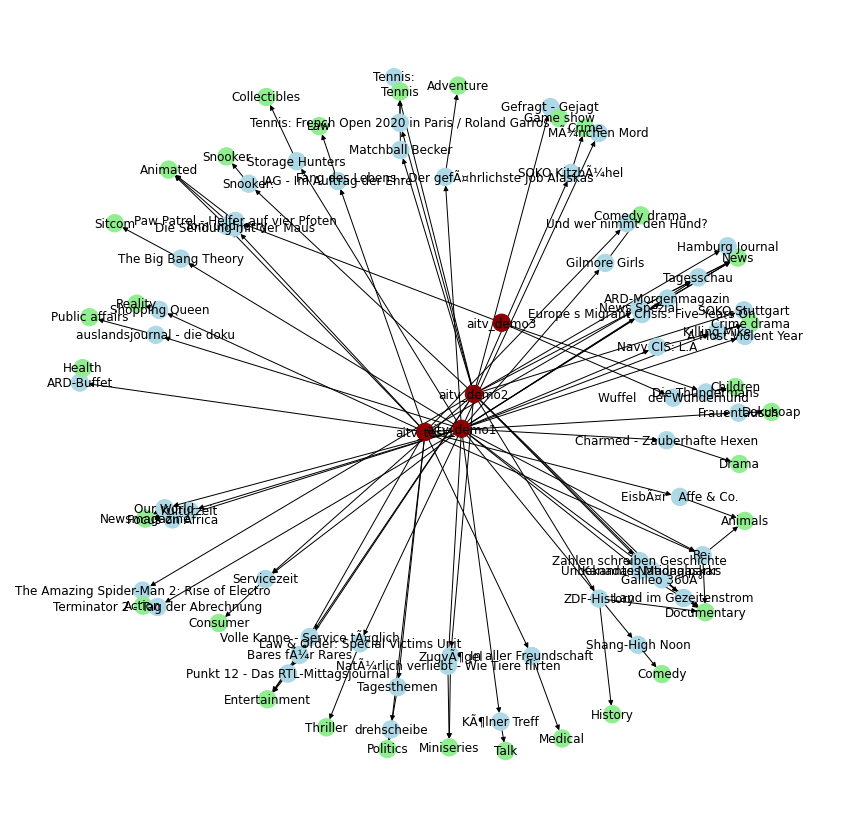

In [10]:
plt.figure(1,figsize=(15,15))
colormap = []
for i in G_label.nodes():
    if G_label.nodes[i]["attr"] == "user":
        colormap.append("darkred")
    elif G_label.nodes[i]["attr"] == "program":
        colormap.append("lightblue")
    elif G_label.nodes[i]["attr"] == "category":
        colormap.append("lightgreen")
nx.draw_networkx(G_label,node_color=colormap)
limits = plt.axis("off")
plt.show()

## define a function to draw subgraph

In [11]:
def draw_subgraph(graph,start_node):
    all_nodes=[]
    def add_all_nodes(graph,node):
        if graph[node] is None:
            return all_nodes
        else:
            for i in graph[node]:
                all_nodes.append(i)
                add_all_nodes(graph,i)
    add_all_nodes(graph,start_node)
    plt.figure(1,figsize=(15,15))
    subgraph = graph.subgraph(all_nodes+[start_node])
    colormap=[]
    for i in subgraph.nodes():
        if subgraph.nodes[i]["attr"] == "user":
            colormap.append("darkred")
        elif subgraph.nodes[i]["attr"] == "program":
            colormap.append("lightblue")
        elif subgraph.nodes[i]["attr"] == "category":
            colormap.append("lightgreen")
    nx.draw_networkx(subgraph, node_color=colormap)
    limits = plt.axis("off")
    plt.show()

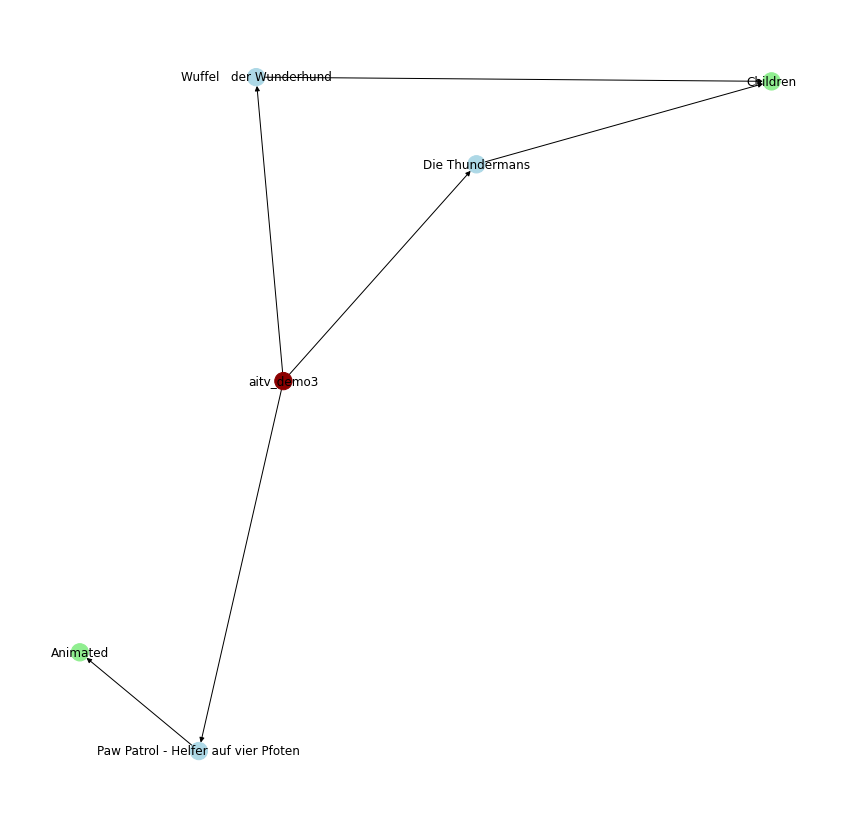

In [12]:
draw_subgraph(G_label,"aitv_demo3")

## visualisation
### dark red: user, blue: program, lightgreen: category

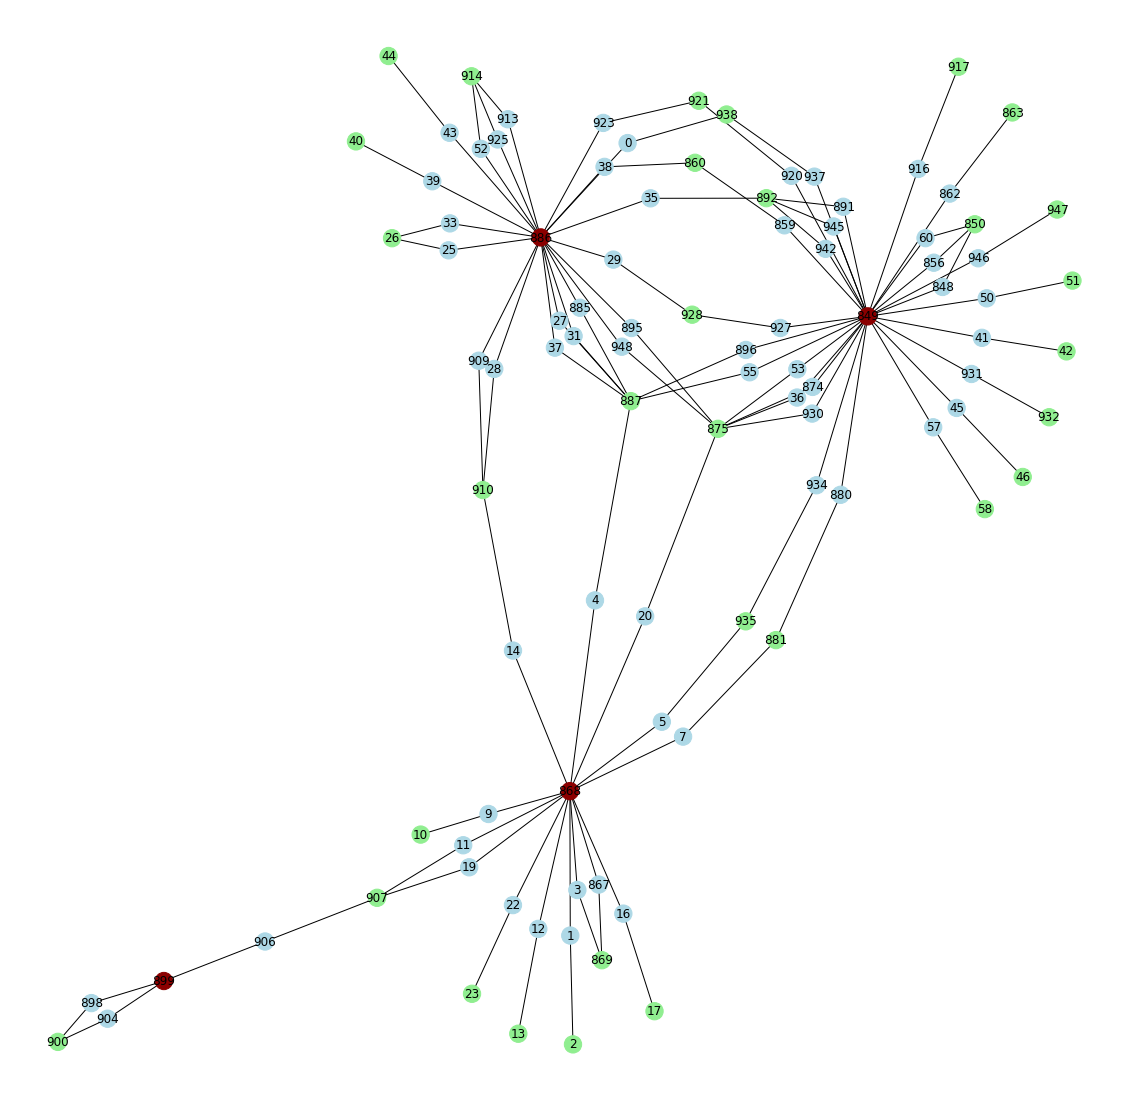

In [14]:
plt.figure(1,figsize=(20,20))
colormap_G = []
for i in G.nodes():
    if G.nodes[i]["attr"] == "user":
        colormap_G.append("darkred")
    elif G.nodes[i]["attr"] == "program":
        colormap_G.append("lightblue")
    elif G.nodes[i]["attr"] == "category":
        colormap_G.append("lightgreen")
nx.draw_networkx(G,node_color=colormap_G)
limits = plt.axis("off")
plt.show()

In [15]:
user_set = set([i for i in G.nodes() if G.nodes[i]["attr"]=="user"])
program_set = set([i for i in G.nodes() if G.nodes[i]["attr"]=="program"])
category_set = set([i for i in G.nodes() if G.nodes[i]["attr"]=="category"])

In [16]:
nx.write_edgelist(G, os.path.join(".","train.edgelist"), comments='#', delimiter=' ', data=False, encoding='utf-8')

# Node2Vec Implementation

- Paper(2016): https://arxiv.org/abs/1607.00653
- Stanford Project: https://snap.stanford.edu/node2vec/
- GITHUB: https://github.com/aditya-grover/node2vec
### node2vec creates node embeddings for the given nodes of a graph, generating a d-dimensional feature vector for each node where d is a tunable parameter in the algorithm.
<img src="node2vec-handsketch.png" width="400">
This means node2vec doesn’t:

- need to know specifics of what your graph represents
- really care about the size of the graph
- can be used for embedding arbitrary undirected monopartite graphs
###  It utilizes a combination of feature learning and a random walk to generalize and scale

### Weighted Random Walk
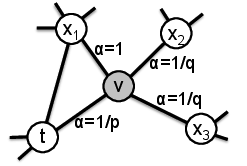

In [17]:
!python node2vec/src/main.py --input train.edgelist --output emb/train.emd

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


In [18]:
!python node2vec/src/main.py --help

usage: main.py [-h] [--input [INPUT]] [--output [OUTPUT]]
               [--dimensions DIMENSIONS] [--walk-length WALK_LENGTH]
               [--num-walks NUM_WALKS] [--window-size WINDOW_SIZE]
               [--iter ITER] [--workers WORKERS] [--p P] [--q Q] [--weighted]
               [--unweighted] [--directed] [--undirected]

Run node2vec.

optional arguments:
  -h, --help            show this help message and exit
  --input [INPUT]       Input graph path
  --output [OUTPUT]     Embeddings path
  --dimensions DIMENSIONS
                        Number of dimensions. Default is 128.
  --walk-length WALK_LENGTH
                        Length of walk per source. Default is 80.
  --num-walks NUM_WALKS
                        Number of walks per source. Default is 10.
  --window-size WINDOW_SIZE
                        Context size for optimization. Default is 10.
  --iter ITER           Number of epochs in SGD
  --workers WORKERS     Number of parallel workers. Default is 8.
  --p P     

In [66]:
# have a look at transformed data, every line starts with the id of the node and followed by a vector of 128 dimensions
with open("emb/train.emd") as f:
    print(f.readline())
    print(f.readline())


98 128

849 -0.21880727 0.14956316 0.051765483 0.14554441 -0.023041766 -0.018182319 0.08630169 0.035194866 -0.1257153 0.07236018 -0.0604078 -0.018118663 0.010968823 0.025360072 -0.03864179 -0.092363395 0.33949202 -0.2098139 0.028157687 -0.03650867 0.05114062 -0.31154066 0.08087047 0.14193411 -0.1384254 -0.22226591 0.18081515 -0.058936924 0.13466886 0.093242064 0.10421334 -0.064163804 0.034374855 -0.29326832 0.05258657 -0.15751132 0.12274098 0.20951374 -0.15318894 0.102130614 -0.089136235 -0.031382233 0.025478411 -0.102771625 -0.0060782693 -0.3020339 0.0756488 0.07717289 -0.35360527 -0.14815322 -0.031186003 -0.10820967 -0.2195393 -0.12561385 -0.27550945 -0.05744981 0.2147936 -0.07727595 -0.10528627 0.0147293545 0.020423083 -0.029166207 0.21322642 -0.033581454 0.04168584 -0.096464075 -0.02352221 0.24289277 -0.04847661 -0.08694868 0.15213096 -0.19199553 0.101268955 -0.07511908 0.2297294 0.16225632 0.106489696 0.044275455 -0.06926728 0.12901427 -0.089756064 -0.21652992 0.046401426 -0.26236

In [20]:
emb_dict = {}
with open(os.path.join(".","emb","train.emd")) as f:
    size, dimension =(int(i) for i in f.readline().split())
    print("size:", size, "dimension: ",dimension)
    for count in range(size):
        line = f.readline()
        emb_dict[int(line.split()[0])]= np.array([float(k) for k in line.split()[1:]])

size: 98 dimension:  128


In [21]:
len(emb_dict)

98

In [22]:
user_set

{849, 868, 886, 899}

In [23]:
user_embedding_dict = {i:emb_dict[i] for i in user_set}
item_embedding_dict = {i:emb_dict[i] for i in program_set}
category_embedding_dict = {i:emb_dict[i] for i in category_set}

In [24]:
user_similarity_matrixs = pd.DataFrame(columns=[encode_dict[i] for i in user_embedding_dict.keys()], 
                                       index=[encode_dict[i] for i in user_embedding_dict.keys()],
                                       data=metrics.pairwise.cosine_similarity(list(user_embedding_dict.values())))
user_similarity_matrixsts

,aitv_demo1,aitv_demo3,aitv_test1,aitv_demo2
aitv_demo1,1.000000,0.161771,0.205270,0.475764
aitv_demo3,0.161771,1.000000,0.681452,0.274678
aitv_test1,0.205270,0.681452,1.000000,0.364223
aitv_demo2,0.475764,0.274678,0.364223,1.000000


In [25]:
pd.DataFrame(columns=["top 3 similarity"],
             data = user_similarity_matrixs.apply(lambda x: dict(zip(x.nlargest(3).index[1:],[round(i, 3) for i in x.nlargest(3)[1:]])), axis=1))

,top 3 similarity
aitv_demo1,"{'aitv_demo2': 0.476, 'aitv_test1': 0.205}"
aitv_demo3,"{'aitv_test1': 0.681, 'aitv_demo2': 0.275}"
aitv_test1,"{'aitv_demo3': 0.681, 'aitv_demo2': 0.364}"
aitv_demo2,"{'aitv_demo1': 0.476, 'aitv_test1': 0.364}"


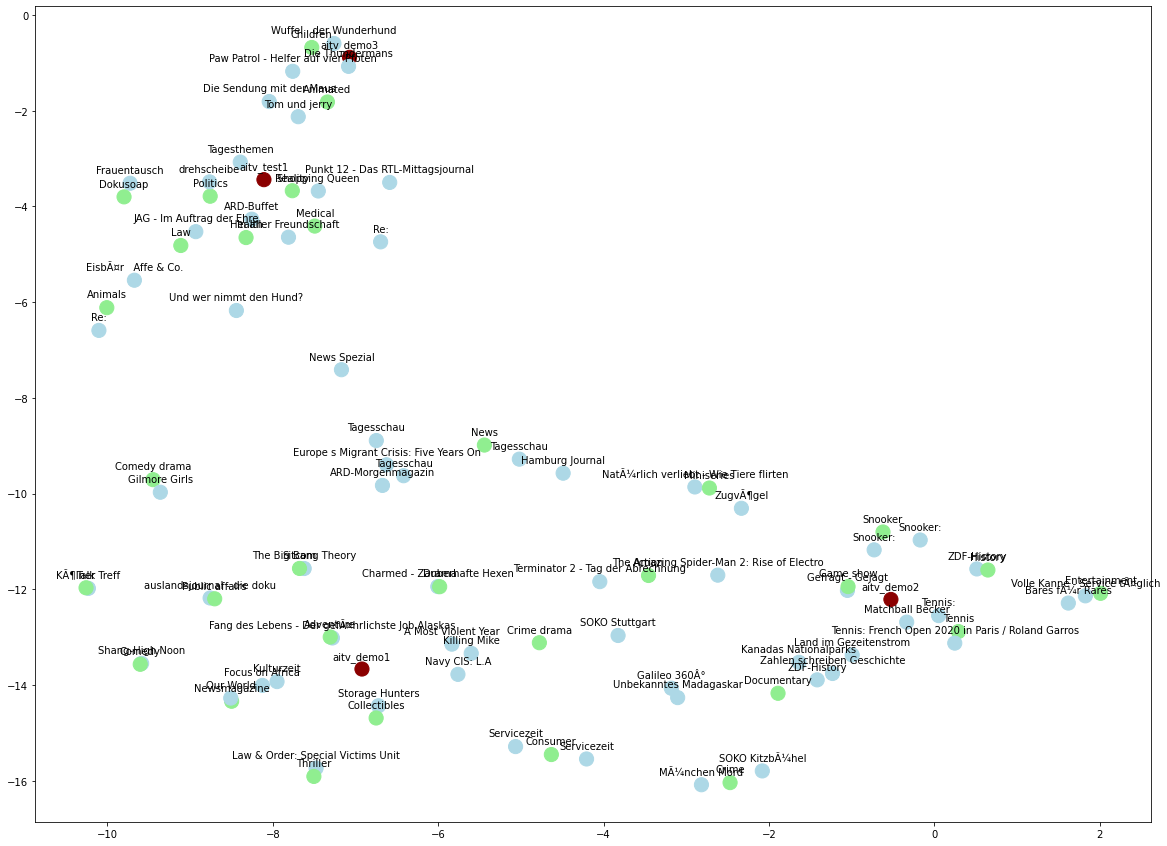

In [26]:
from sklearn.manifold import TSNE
emb_dict_color = []
for i in emb_dict.keys():
    if i in user_set:
        emb_dict_color.append("darkred")
    elif i in program_set:
        emb_dict_color.append("lightblue")
    elif i in category_set:
        emb_dict_color.append("lightgreen")
tsne = TSNE(n_components=2,random_state=1, n_iter=15000, metric="cosine")
embs = tsne.fit_transform(np.array(list(emb_dict.values())))
fig, ax = plt.subplots(figsize=(20,15))
ax.scatter(embs[:, 0],embs[:, 1],color=emb_dict_color,s=200,label=list(emb_dict.keys()))
for i in range(len(embs)):
    plt.annotate(encode_dict[list(emb_dict.keys())[i]], # this is the text
                     embs[i], # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center')

# implement ANN with ANNOY(from Spotify)
https://github.com/spotify/annoy
- "We use it at Spotify for music recommendations. After running matrix factorization algorithms, every user/item can be represented as a vector in f-dimensional space. This library helps us search for similar users/items. We have many millions of tracks in a high-dimensional space, so memory usage is a prime concern."

In [27]:
import annoy
from annoy import AnnoyIndex

In [38]:
# embedding size
filtered_dict = {i:emb_dict[i] for i in emb_dict if i in user_set.union(program_set)}
print("added nodes: ", len(filtered_dict))
f = 128
t = AnnoyIndex(f, 'angular')
for i in filtered_dict:
    t.add_item(i, filtered_dict[i])

added nodes:  67


In [39]:
t.build(10)
t.save('train.ann')

True

# recommendation!

In [45]:
[(i,encode_dict[i]) for i in user_set]

[(849, 'aitv_demo1'),
 (899, 'aitv_demo3'),
 (868, 'aitv_test1'),
 (886, 'aitv_demo2')]

In [43]:
USER = 849

In [56]:
u = AnnoyIndex(f, 'angular')
u.load('train.ann') # super fast, will just mmap the file
for k in  u.get_nns_by_item(USER, 10):
    if k not in user_set:# will find the 10 nearest neighbors
        print("recommender_system for {}: {} -----".format(USER, encode_dict[USER]), k, encode_dict[k])

recommender_system for 849: aitv_demo1 ----- 856 Kulturzeit
recommender_system for 849: aitv_demo1 ----- 848 Focus on Africa
recommender_system for 849: aitv_demo1 ----- 45 Storage Hunters
recommender_system for 849: aitv_demo1 ----- 931 Fang des Lebens - Der gefÃ¤hrlichste Job Alaskas
recommender_system for 849: aitv_demo1 ----- 891 Navy CIS: L.A
recommender_system for 849: aitv_demo1 ----- 945 Killing Mike
recommender_system for 849: aitv_demo1 ----- 942 A Most Violent Year
recommender_system for 849: aitv_demo1 ----- 927 Servicezeit
recommender_system for 849: aitv_demo1 ----- 937 Terminator 2 - Tag der Abrechnung
